In [1]:
import sys
import time
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, BatchNormalization, Flatten, Reshape, Activation, Dense, UpSampling2D, LeakyReLU, Input, MaxPool2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session=tf.compat.v1.InteractiveSession(config=config)

In [11]:
images=list()
for i in range(1,1200):
    a=cv2.imread("img_align_celeba/%06d.jpg"%i,1)
    a=cv2.resize(a,(256,256))
    a=a/255.0
    a=a.tolist()
    images.append(a)
    print("%d"%i, end='\r')
images=np.asarray(images)
np.save('data.npy',images)

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [3]:
images = np.load('data.npy')

In [41]:
def gen(inputs, image_shape):
    x=Dense((image_shape[0]//64) * (image_shape[1]//64) * 128, activation='relu')(inputs)
    x=Reshape(((image_shape[0]//64), (image_shape[1]//64), 128))(x)
    
    x=UpSampling2D()(x)
    x=Conv2DTranspose(filters = 512, kernel_size=3, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    #x=Activation('sigmoid')(x)
    
    x=UpSampling2D()(x)
    x=Conv2DTranspose(filters = 256, kernel_size=3, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    #x=Activation('sigmoid')(x)
    
    x=UpSampling2D()(x)
    x=Conv2DTranspose(filters = 128, kernel_size=3, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    #x=Activation('sigmoid')(x)
    
    x=UpSampling2D()(x)
    x=Conv2DTranspose(filters = 64, kernel_size=3, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    #x=Activation('sigmoid')(x)

    x=UpSampling2D()(x)
    x=Conv2DTranspose(filters = 32, kernel_size=3, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    #x=Activation('sigmoid')(x)

#    x=Conv2DTranspose(filters = 32, kernel_size=3, strides=1, padding='same', activation = 'sigmoid')(x)
#    x=BatchNormalization()(x)

    x=UpSampling2D()(x)
    x=Conv2DTranspose(filters = 3, kernel_size=3, padding='same')(x)
    #x=LeakyReLU(alpha=0.2)(x)
    x=Activation('sigmoid')(x)
    
    generator=Model(inputs, x)
    return generator

In [42]:
def dis(inputs):
    x=inputs
    
    x= Conv2D(filters= 64, kernel_size=3, strides=2, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPool2D()(x)
    
    x= Conv2D(filters= 128, kernel_size=3, strides=2, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPool2D()(x)
    
    x= Conv2D(filters= 256, kernel_size=3, strides=2, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPool2D()(x)
    
    x= Conv2D(filters= 512, kernel_size=3, strides=1, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPool2D()(x)
    
    '''x= Conv2D(filters= 512, kernel_size=3, strides=1, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPool2D()(x)

    x= Conv2D(filters= 1024, kernel_size=3, strides=1, padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPool2D()(x)'''
    
    x=Flatten()(x)
    x=Dense(512, activation='relu')(x)
    x=Dense(1, activation = 'sigmoid')(x)
    
    discriminator = Model(inputs, x)
    return discriminator

In [51]:
def models(latent_size):
    input_shape=(images.shape[1],images.shape[2],3)
    
    inputs = Input(shape=input_shape)
    discriminator=dis(inputs)
    discriminator.compile(loss = 'binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001, momentum=0.01), metrics = ['accuracy'])
    
    inputs = Input(shape=(latent_size))
    generator=gen(inputs, input_shape)
    
    discriminator.trainable = False
    
    adversarial=Model(inputs, discriminator(generator(inputs)))
    adversarial.compile(loss='binary_crossentropy', optimizer = RMSprop(learning_rate=0.0001, momentum=0.03))

    models=(generator, discriminator, adversarial)
    return models

In [52]:
def train(models, epochs, batch_size, latent_size, save_interval=0, mod_save_interval=0):
    tg=time.time()
    generator, discriminator, adversarial = models
    history={
        "adversarial loss":list(),
        "discriminator loss":list(),
        "discriminator accuracy":list()
    }
    for i in range(epochs):
        t1=time.time()
        
        rand_indices = np.random.randint(0, images.shape[0], size = batch_size)
        real = images[rand_indices]
        noise = np.random.random([batch_size, latent_size,1])
        fake = generator.predict(noise)
        
        x = np.concatenate((real,fake))
        
        y = np.ones(batch_size*2)
        y[batch_size:]=0.0
        y=np.reshape(y,(batch_size*2,1))
        
        history2 = discriminator.train_on_batch(x,y)
        
        noise = np.random.random([batch_size, latent_size,1])
        y=np.ones(batch_size)
        y=np.reshape(y,(batch_size,1))
        
        """aloss, aacc =""" 
        history1 = adversarial.train_on_batch(noise, y)
        
        t2=time.time()
        history["adversarial loss"].append(history1)
        history["discriminator loss"].append(history2[0])
        history["discriminator accuracy"].append(history2[1])
        print("Epoch : %d, [adversarial loss: %f] [discriminator loss: %f, acc: %f] time : %.4fs"%(i+1, history1, history2[0], history2[1], t2-t1))

        
        if save_interval!=0:
            if (i+1)%save_interval==0:
                noise = np.random.uniform(0, 1.0, size = [1, latent_size])
                n=generator.predict(noise)
                n=n[0]
                n*=255
                cv2.imwrite("images/%d.jpeg"%(i+1),n)
                print("Saved!")
        if mod_save_interval!=0:
            if (i+1)%mod_save_interval==0:
                generator.save('models/gen%d.h5'%(i+1))
                print("Generator Saved")
    print("Total time taken : "+str(-tg+time.time()))
    return history

In [53]:
model=models(500)
with tf.device('/gpu:0'):
    hist=train(model, 20000, 64, 500, 10, 200)

tor loss: 0.000010, acc: 1.000000] time : 0.1968s
Epoch : 19813, [adversarial loss: 8.692707] [discriminator loss: 0.000010, acc: 1.000000] time : 0.1921s
Epoch : 19814, [adversarial loss: 12.236493] [discriminator loss: 0.001602, acc: 1.000000] time : 0.1880s
Epoch : 19815, [adversarial loss: 8.563256] [discriminator loss: 0.000034, acc: 1.000000] time : 0.2045s
Epoch : 19816, [adversarial loss: 7.739404] [discriminator loss: 0.000056, acc: 1.000000] time : 0.1938s
Epoch : 19817, [adversarial loss: 6.025800] [discriminator loss: 0.000049, acc: 1.000000] time : 0.1757s
Epoch : 19818, [adversarial loss: 5.873279] [discriminator loss: 0.000126, acc: 1.000000] time : 0.1838s
Epoch : 19819, [adversarial loss: 5.084891] [discriminator loss: 0.000194, acc: 1.000000] time : 0.1889s
Epoch : 19820, [adversarial loss: 3.936896] [discriminator loss: 0.000045, acc: 1.000000] time : 0.1939s
Saved!
Epoch : 19821, [adversarial loss: 4.798451] [discriminator loss: 0.000171, acc: 1.000000] time : 0.187

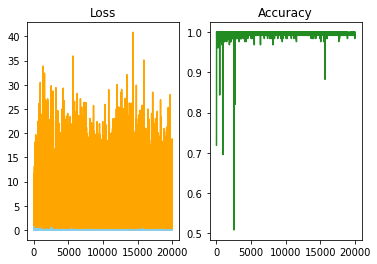

In [54]:
fig=plt.figure()
ax1=fig.add_subplot(121)
ax1.plot(hist["adversarial loss"], color='#ffa500', label="Adversarial loss")
ax1.plot(hist["discriminator loss"], color='#87ceeb', label="Discriminator loss")
ax1.set_title("Loss")
ax2=fig.add_subplot(122)
ax2.plot(hist["discriminator accuracy"], color='#228b22', label="Discriminator accuracy")
ax2.set_title("Accuracy")
fig.savefig("resources/performance.png",dpi=300)

In [55]:
generator, discriminator, adversarial = model
generator.save('models/generator.h5')
discriminator.save('models/discriminator.h5')
adversarial.save('models/adversarial.h5')